# ***Hand Gesture Classification***

- Đầu vào: Hình ảnh hành động của tay
- Đầu ra: dự đoán nhãn cho hành động mà tay đang làm
- Bài toán: multi-class classification (phân loại đa lớp), phân loại các hand gestures vào các lớp

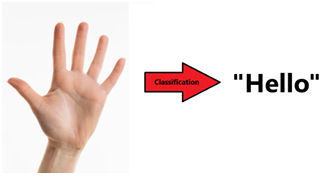

Bài toán này có thể có nhiều cách tiếp cận khác nhau.
- Nếu xét theo cách thu nhận và biểu diễn cử chỉ tay thì bài toán có thể được chia thành **skeleton based** và **box/filter-based**.

- Còn nếu xét dựa trên kỹ thuật nhận dạng, bài toán có thể chia thành cách tiếp cận **sử dụng Neural Networks** (Deep Learning Approaches) và **không dùng Neural Networks**.

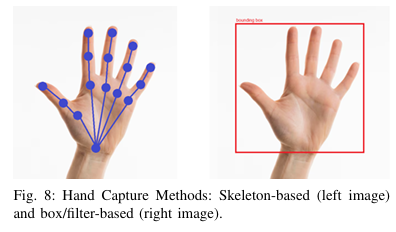


Nhóm sẽ phân tích theo 3 hướng: box/filter-based + ML, box/filter-based + DL, skeleton-based + DL

# **A. Chuẩn bị dữ liệu**

Dataset: **NUS Hand Posture Dataset 2**, gồm 2000 ảnh hand postures, 750 ảnh hand postures có nhiễu; gồm 10 lớp (classes)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Tải dataset
import os
download_path = '/content/drive/MyDrive/HandGestureRecognition/datasets'
os.makedirs(download_path, exist_ok = True)

url = 'https://www.ece.nus.edu.sg/stfpage/elepv/NUS-HandSet/NUS-Hand-Posture-Dataset-II.zip'
zip_file_name = 'NUS-Hand-Posture-Dataset-II.zip'
file_name = 'NUS-Hand-Posture-Dataset-II'
!wget -O $download_path/$file_name $url

--2025-05-16 20:52:14--  https://www.ece.nus.edu.sg/stfpage/elepv/NUS-HandSet/NUS-Hand-Posture-Dataset-II.zip
Resolving www.ece.nus.edu.sg (www.ece.nus.edu.sg)... 137.132.5.15
Connecting to www.ece.nus.edu.sg (www.ece.nus.edu.sg)|137.132.5.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 77233719 (74M) [application/x-zip-compressed]
Saving to: ‘/content/drive/MyDrive/HandGestureRecognition/datasets/NUS-Hand-Posture-Dataset-II’

/content/drive/MyDr 100%[===================>]  73.66M   293KB/s    in 4m 27s  

2025-05-16 20:56:46 (282 KB/s) - ‘/content/drive/MyDrive/HandGestureRecognition/datasets/NUS-Hand-Posture-Dataset-II’ saved [77233719/77233719]



In [ ]:
# Giải nén file ZIP datatset
zip_file_path = os.path.join(download_path, file_name)
!unzip -q {zip_file_path} -d {download_path}

In [ ]:
#Tạo dataframe
import pandas as pd
import numpy as np
import os

without_noise_img_dir ='/content/drive/MyDrive/HandGestureRecognition/datasets/NUS Hand Posture dataset-II/Hand Postures'
noise_img_dir = '/content/drive/MyDrive/HandGestureRecognition/datasets/NUS Hand Posture dataset-II/Hand Postures with human noise'

file_paths = []
labels = []

for img in os.listdir(without_noise_img_dir):
  if img.endswith(('jpg', 'jpeg', 'png')):
    first_letter = img[0]
    labels.append(img[0])
    file_paths.append(os.path.join(without_noise_img_dir, img))


for img in os.listdir(noise_img_dir):
    if img.endswith(('jpg', 'jpeg', 'png')):
      labels.append(img[0])
      file_paths.append(os.path.join(noise_img_dir, img))


In [ ]:
df = pd.DataFrame({'file_path': file_paths, 'label': labels})
df

,file_path,label
0,/content/drive/MyDrive/HandGestureRecognition/...,a
1,/content/drive/MyDrive/HandGestureRecognition/...,a
2,/content/drive/MyDrive/HandGestureRecognition/...,a
3,/content/drive/MyDrive/HandGestureRecognition/...,a
4,/content/drive/MyDrive/HandGestureRecognition/...,a
...,...,...
2745,/content/drive/MyDrive/HandGestureRecognition/...,j
2746,/content/drive/MyDrive/HandGestureRecognition/...,j
2747,/content/drive/MyDrive/HandGestureRecognition/...,j
2748,/content/drive/MyDrive/HandGestureRecognition/...,j


<ipython-input-48-917e4261286f>:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.text(i, label_counts[i] + 1, str(label_counts[i]), ha='center', va='bottom')


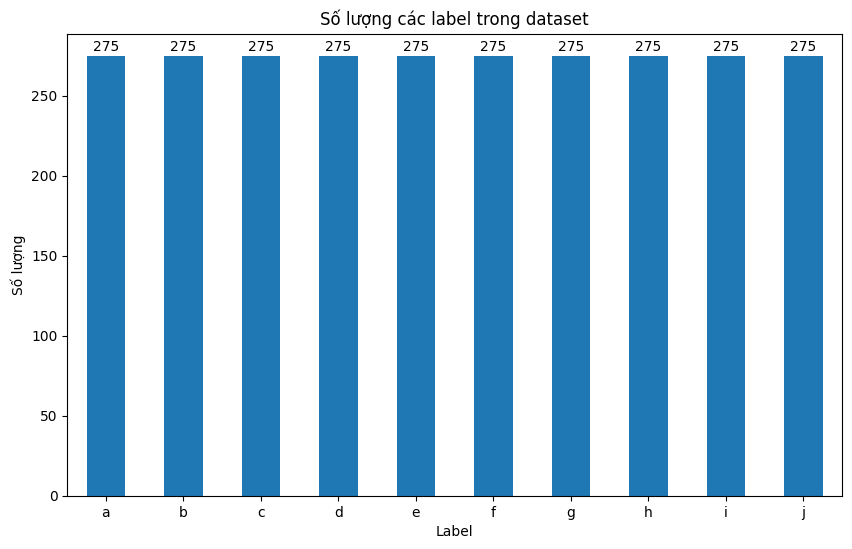

In [ ]:
import matplotlib.pyplot as plt

# Đếm số lượng mỗi label
label_counts = df['label'].value_counts()

# Vẽ biểu đồ cột (bar chart)
plt.figure(figsize=(10, 6))
ax = label_counts.plot(kind='bar')

plt.title('Số lượng các label trong dataset')
plt.xlabel('Label')
plt.ylabel('Số lượng')
plt.xticks(rotation=0)


for i in range(len(label_counts)):
    ax.text(i, label_counts[i] + 1, str(label_counts[i]), ha='center', va='bottom')

plt.show()

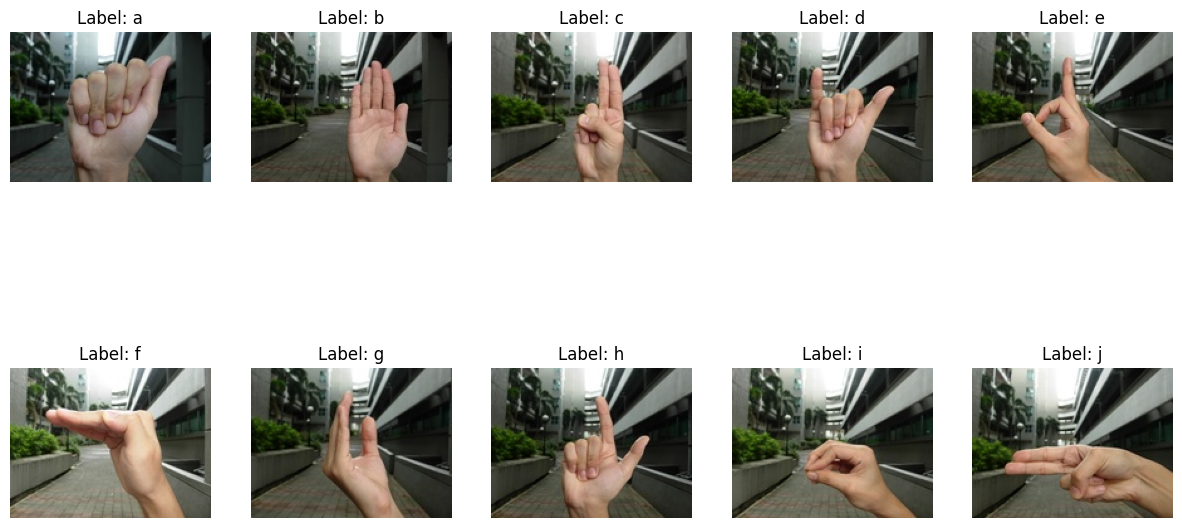

In [51]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(15, 8))

# Duyệt qua từng nhãn
unique_labels = df['label'].unique()

for i, label in enumerate(unique_labels):
    # Lấy đường dẫn ảnh đầu tiên có nhãn đó
    sample_img_path = df[df['label'] == label].iloc[1]['file_path']

    # Đọc ảnh
    img = mpimg.imread(sample_img_path)

    # Hiển thị ảnh
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.axis('off')
plt.show()


In [67]:
df.to_csv(os.path.join(download_path, 'data.csv'), index=False)

# **B. Định nghĩa mô hình**

## I. Box/filter-based  - ML

Sử dụng SVM + HOG (Histogram of gradients)

## II. Box/filter-based + DL
Sử dụng mạng CNN để trích xuất đặc trưng và gán nhãn

## III. Skeleton-based + DL
Sử dụng mediapipe + MLP

#**B. So sánh kết quả, nhận xét và kểt luận**

In ra cofusion metrix, acc, f1, precision, recall

#**C. Tài liệu tham khảo**
1. Linardakis, Manousos, Iraklis Varlamis, and Georgios Th Papadopoulos. "Survey on Hand Gesture Recognition from Visual Input." arXiv preprint arXiv:2501.11992 (2025).